<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigureS3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Importe libraries and functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import warnings
from scipy.stats import ttest_rel
import statsmodels.stats.multitest as smm
from statsmodels.stats.power import TTestPower

# Function for stars
def p_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

warnings.filterwarnings("ignore")

Statistical comparison (paired t-tests vs saline with Bonferroni correction):

0.2 mg/kg  | t = -0.586 | p = 0.5763 | corrected p = 1 | significant: ns
0.3 mg/kg  | t =  1.420 | p = 0.1986 | corrected p = 0.7944 | significant: ns
0.4 mg/kg  | t =  8.333 | p = 7.021e-05 | corrected p = 0.0002808 | significant: ***
0.6 mg/kg  | t =  9.327 | p = 3.381e-05 | corrected p = 0.0001352 | significant: ***


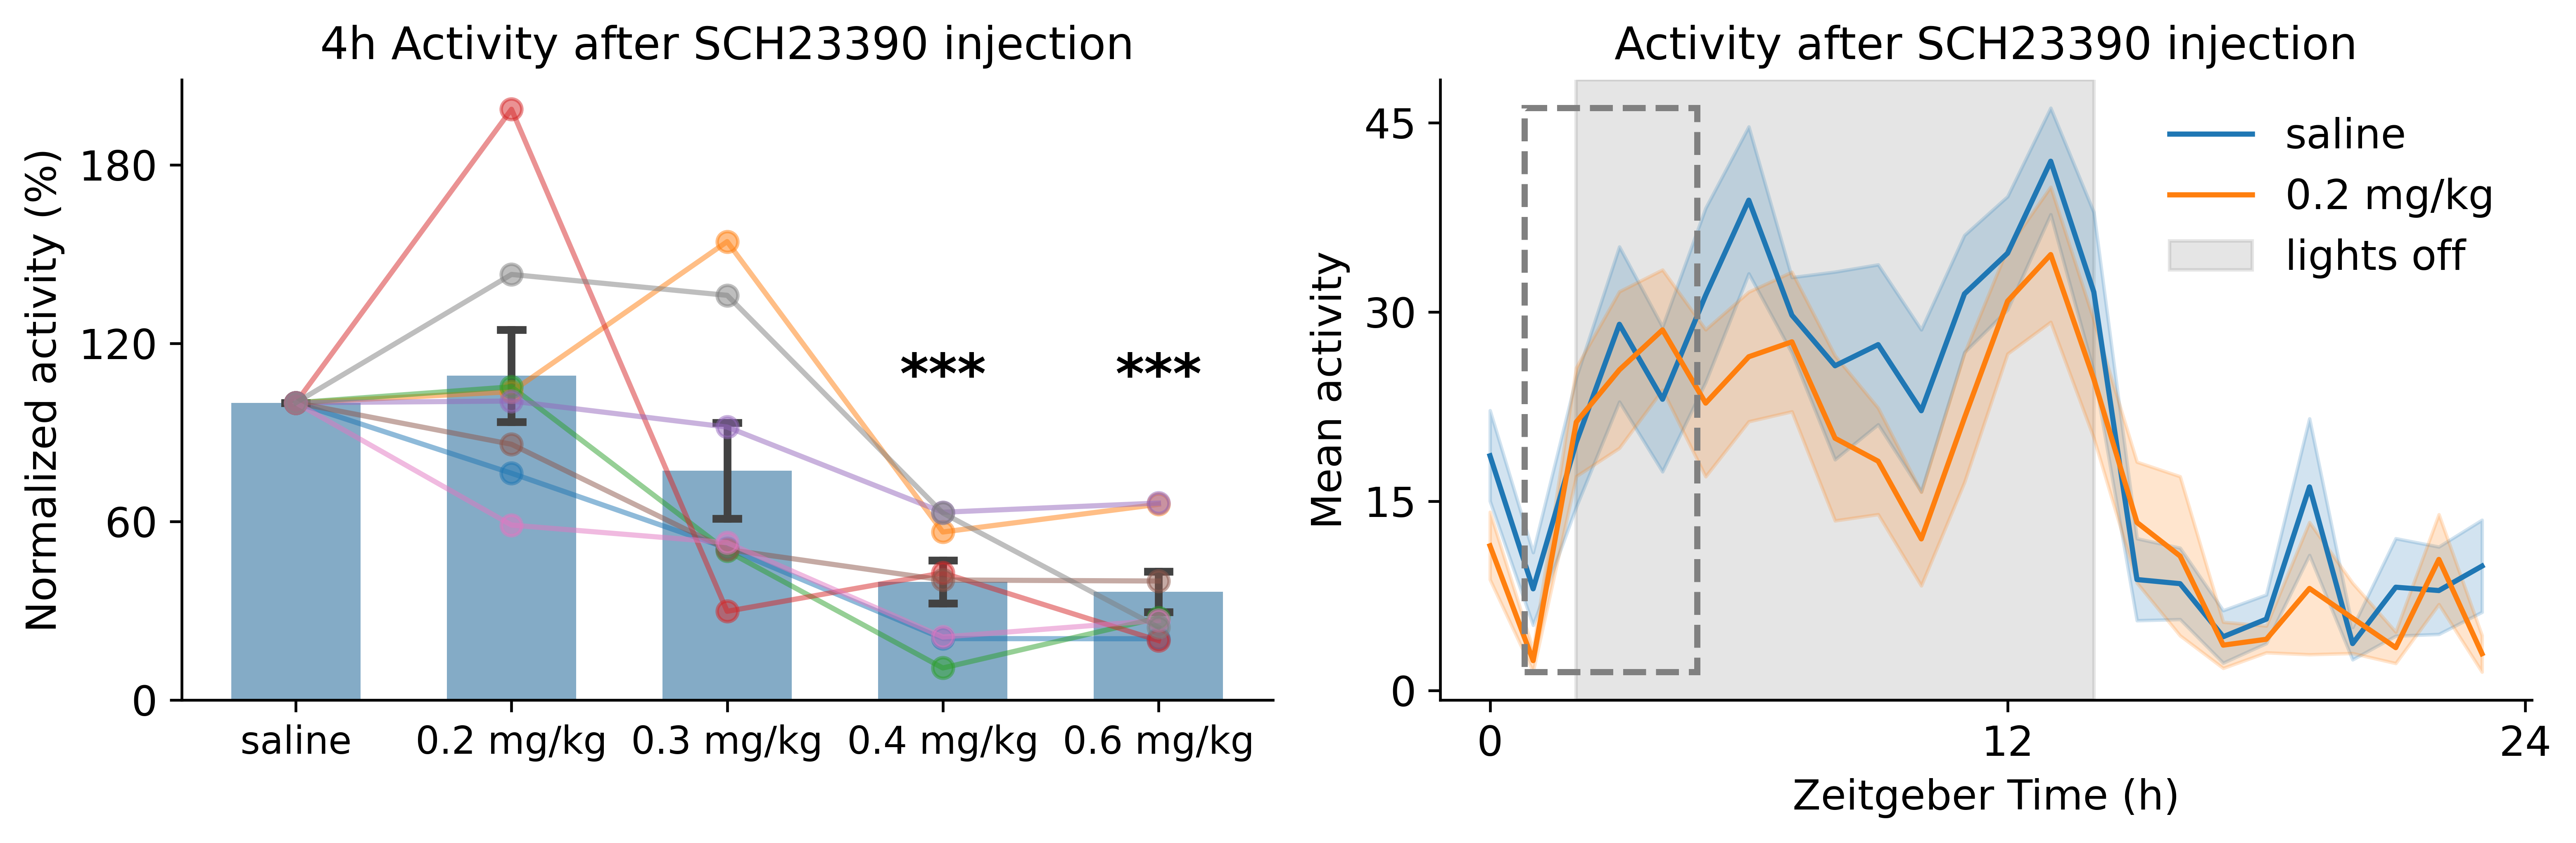

In [2]:
# @title Figure S3A-B
# Load and preprocess data
df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/SCH23390_activity_FigureS3.csv")

df1 = df.query('hour > 16 and hour <= 20')
ids = ['553', '549', '561', 'EB0', 'E95', 'EA2', 'E94', 'E8D']
df_means = df1.groupby('day')[ids].mean().reset_index()
day_mapping = {
    1.0: 'saline',
    2.0: '0.2 mg/kg', #10x
    3.0: '0.3 mg/kg', #15x
    4.0: '0.4 mg/kg', #20x
    5.0: '0.6 mg/kg', #30x
}

# Melting the dataframe to long format for seaborn barplot
df_melted = df_means.melt(id_vars='day', var_name='id', value_name='mean')
df_melted['day_label'] = df_melted['day'].map(day_mapping)
df_melted = df_melted.dropna()
desired_order = ['saline', '0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']

# Convert 'day_label' to a categorical type with the desired order
df_melted['day_label'] = pd.Categorical(df_melted['day_label'], categories=desired_order, ordered=True)

# Sort the dataframe by the 'day_label' column
df_melted = df_melted.sort_values(by='day_label')
saline_means = df_melted[df_melted['day_label'] == 'saline'].set_index('id')['mean']

# Apply normalization
df_melted['mean_normalized'] = df_melted.apply(lambda x: x['mean'] *100/ saline_means[x['id']], axis=1)

# Prepare data
conditions = ['0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
saline_vals = df_melted[df_melted['day_label'] == 'saline'].set_index('id')['mean_normalized']

# Run paired t-tests
pvals = []
comparisons = []

for condition in conditions:
    drug_vals = df_melted[df_melted['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    pvals.append(p)
    comparisons.append((condition, p))

# Bonferroni correction
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='bonferroni')

print("Statistical comparison (paired t-tests vs saline with Bonferroni correction):\n")
for (condition, raw_p), corrected_p, rej in zip(comparisons, pvals_corrected, reject):
    drug_vals = df_melted[df_melted['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    star = p_to_star(corrected_p)
    print(f"{condition:<10} | t = {tstat:>6.3f} | p = {raw_p:.4g} | corrected p = {corrected_p:.4g} | significant: {star or 'ns'}")

# Function for stars
def p_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.5), dpi=600)

# Figure 1: Barplot with line plots
ax1 = axes[0]
sns.barplot(
    data=df_melted,  # df_melted for Figure 1
    x='day_label',
    y='mean_normalized',
    errorbar='se',
    alpha=0.6,
    capsize=0.1,
    width=0.6,
    ax=ax1
)

for individual_id in df_melted['id'].unique():
    individual_data = df_melted[df_melted['id'] == individual_id]
    ax1.plot(
        individual_data['day_label'],
        individual_data['mean_normalized'],
        marker='o',
        linestyle='-',
        label=individual_id,
        zorder=4,
        alpha=0.5
    )

ax1.set_title('4h Activity after SCH23390 injection', fontsize=13)
ax1.set_ylabel('Normalized activity (%)', fontsize=12)
ax1.set_xlabel('', fontsize=12)
custom_labels = ['saline', '0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
ax1.set_xticks(range(len(custom_labels)))
ax1.set_xticklabels(custom_labels, fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.tick_params(axis='y', labelsize=12)
ax1.legend([], frameon=False)

y_offset = df_melted['mean_normalized'].max() * .5
for i, (condition, p_corr) in enumerate(zip(conditions, pvals_corrected), start=1):  # start=1 to match bar positions
    star = p_to_star(p_corr)
    if star:
        ax1.text(
            i, y_offset, star,
            ha='center',
            va='bottom',
            fontsize=16,
            color='black',
            fontweight='bold'
        )

sns.despine(ax=ax1, top=True, right=True)

day_mapping = {
    1.0: 'saline',
    2.0: '0.2 mg/kg',#'10x',
}

ids = ['553', '549', '561', 'EB0', 'E95', 'EA2', 'E94', 'E8D']
df_means = df.groupby(['day','zthour'])[ids].mean().reset_index()
df_means['day_label'] = df_means['day'].map(day_mapping)
df_melted = df_means.melt(id_vars=['day','zthour','day_label'], var_name='id', value_name='mean')
df_melted = df_melted.dropna()
# Figure 2: Lineplot
ax2 = axes[1]
sns.lineplot(
    data=df_melted,  # df_melted for Figure 2
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax2
)

x_ticks = [0, 12, 24]
x_tick_labels = ['0', '12', '24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=12)
ax2.set_ylabel("Mean activity", fontsize=12)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=12)
ax2.tick_params(axis='y',labelsize = 12)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax2.legend(loc='upper right', frameon=False, fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Activity after SCH23390 injection', fontsize=13)

import matplotlib.patches as patches

# Compute mean and SEM for each group
summary = df_melted.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()

# Compute global ymin and ymax across the whole time range
summary['lower'] = summary['mean'] - summary['sem']
summary['upper'] = summary['mean'] + summary['sem']
ymin = summary['lower'].min()
ymax = summary['upper'].max()

# Create and add the dashed rectangle from ZT1 to ZT5
box = patches.Rectangle(
    (0.8, ymin),           # Lower-left corner: ZT1
    4,                   # Width from ZT1 to ZT5 (ZT5 − ZT1 = 4)
    ymax - ymin,         # Height from global lower to upper bound
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax2.add_patch(box)

# Adjust layout
plt.tight_layout()
plt.show()

Statistical comparison (paired t-tests vs saline with Bonferroni correction):

0.1 mg/kg  | t =  0.878 | p = 0.4092 | corrected p = 1 | significant: ns
0.2 mg/kg  | t =  7.445 | p = 0.0001439 | corrected p = 0.0005754 | significant: ***
0.4 mg/kg  | t =  4.788 | p = 0.001993 | corrected p = 0.007973 | significant: **
0.6 mg/kg  | t =  4.912 | p = 0.001729 | corrected p = 0.006916 | significant: **


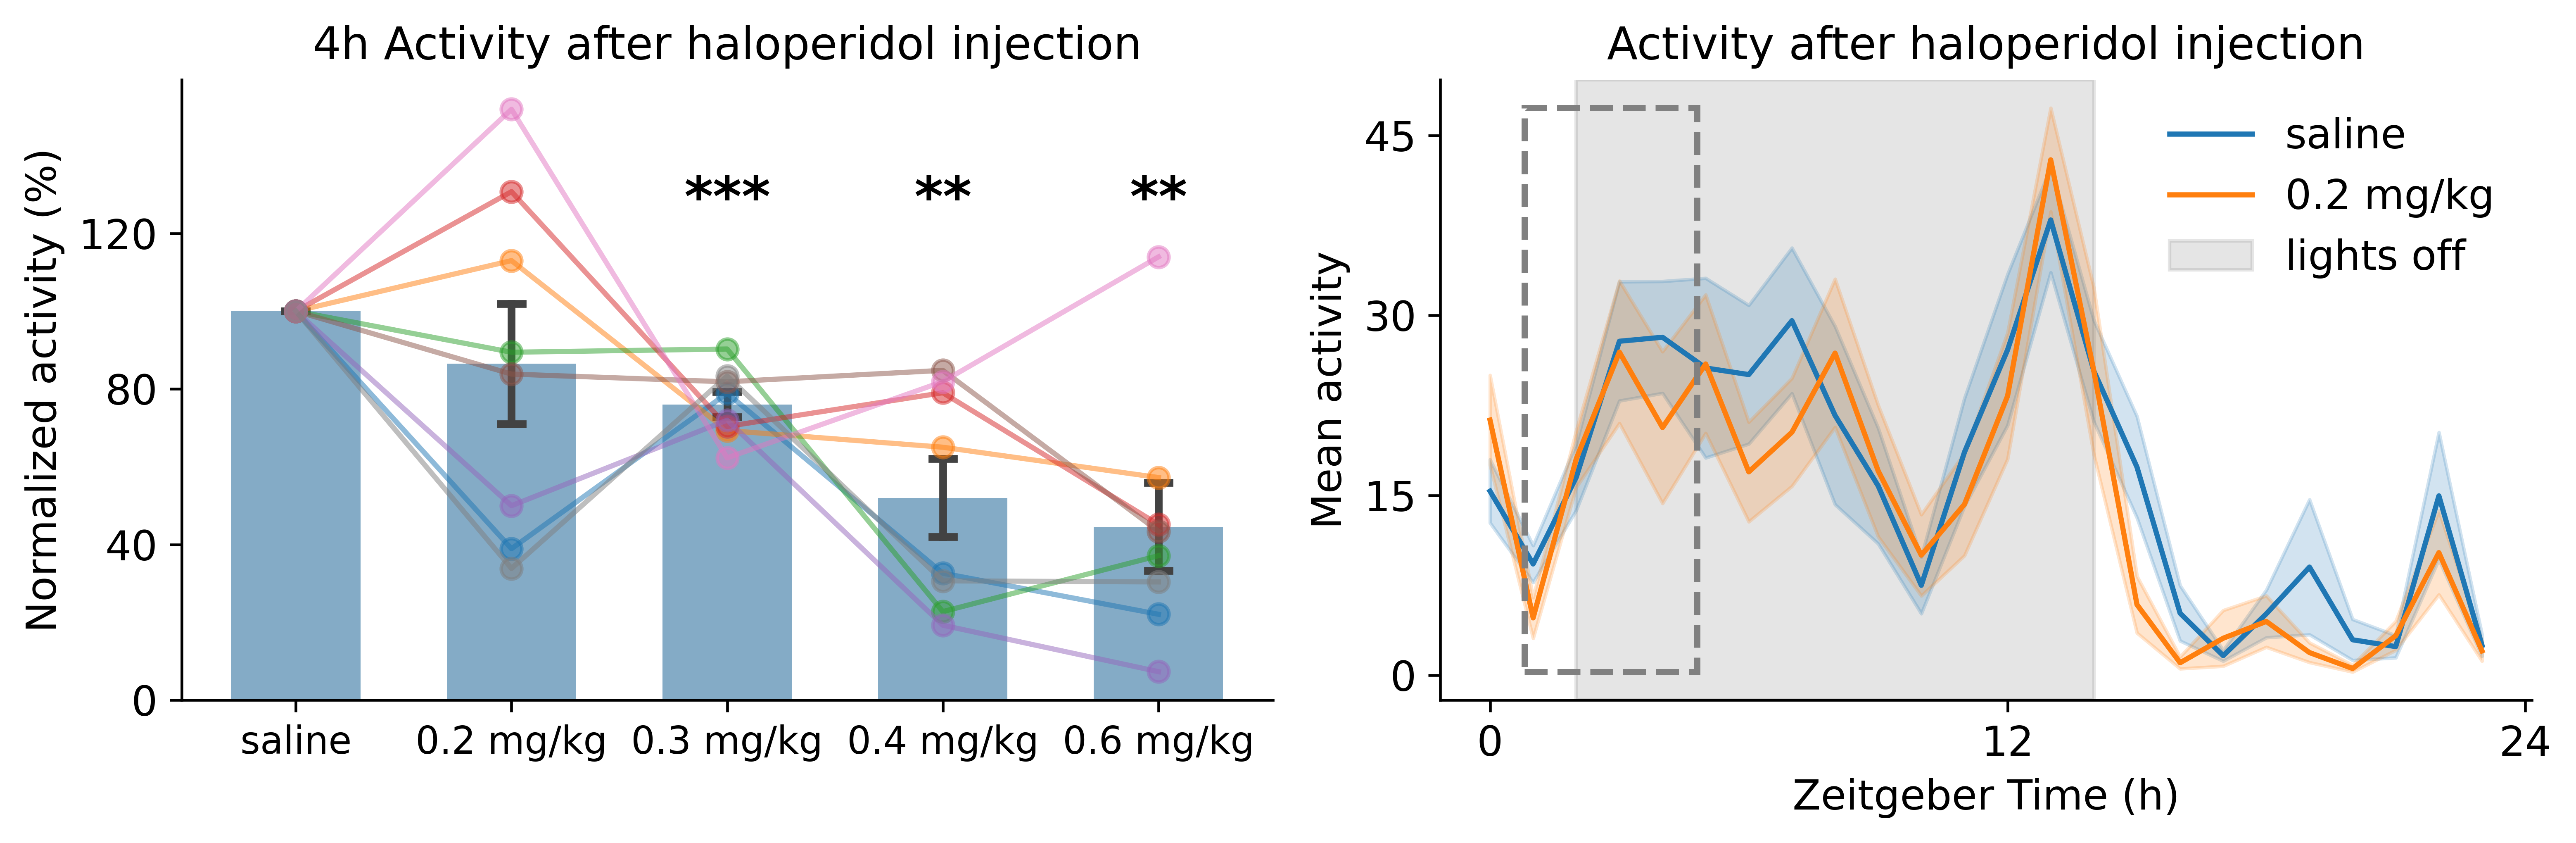

In [3]:
# @title Figure S3C-D
# Load and preprocess data
df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/haloperidol_activity_FigureS3.csv")
df1 = df.query('hour > 16 and hour <= 20')
ids = ['553', '549', '561', 'EB0', 'E95', 'EA2', 'E94', 'E8D']
df_means = df1.groupby('day')[ids].mean().reset_index()
day_mapping = {
    3.0: 'saline',
    4.0: '0.2 mg/kg',
    9.0: '0.4 mg/kg',
    11.0: '0.1 mg/kg',
    13.0: '0.6 mg/kg',
}

# Melting the dataframe to long format for seaborn barplot
df_melted = df_means.melt(id_vars='day', var_name='id', value_name='mean')
df_melted['day_label'] = df_melted['day'].map(day_mapping)
df_melted = df_melted.dropna()
desired_order = ['saline', '0.1 mg/kg', '0.2 mg/kg', '0.4 mg/kg', '0.6 mg/kg']

# Convert 'day_label' to a categorical type with the desired order
df_melted['day_label'] = pd.Categorical(df_melted['day_label'], categories=desired_order, ordered=True)

# Sort the dataframe by the 'day_label' column
df_melted = df_melted.sort_values(by='day_label')
saline_means = df_melted[df_melted['day_label'] == 'saline'].set_index('id')['mean']

# Apply normalization
df_melted['mean_normalized'] = df_melted.apply(lambda x: x['mean'] *100/ saline_means[x['id']], axis=1)

# Prepare data
conditions = ['0.1 mg/kg', '0.2 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
saline_vals = df_melted[df_melted['day_label'] == 'saline'].set_index('id')['mean_normalized']

# Run paired t-tests
pvals = []
comparisons = []

for condition in conditions:
    drug_vals = df_melted[df_melted['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    pvals.append(p)
    comparisons.append((condition, p))

# Bonferroni correction
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='bonferroni')

print("Statistical comparison (paired t-tests vs saline with Bonferroni correction):\n")
for (condition, raw_p), corrected_p, rej in zip(comparisons, pvals_corrected, reject):
    drug_vals = df_melted[df_melted['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    star = p_to_star(corrected_p)
    print(f"{condition:<10} | t = {tstat:>6.3f} | p = {raw_p:.4g} | corrected p = {corrected_p:.4g} | significant: {star or 'ns'}")

fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.5), dpi=600)

# Figure 1: Barplot with line plots
ax1 = axes[0]
sns.barplot(
    data=df_melted,  # df_melted for Figure 1
    x='day_label',
    y='mean_normalized',
    errorbar='se',
    alpha=0.6,
    capsize=0.1,
    width=0.6,
    ax=ax1
)

for individual_id in df_melted['id'].unique():
    individual_data = df_melted[df_melted['id'] == individual_id]
    ax1.plot(
        individual_data['day_label'],
        individual_data['mean_normalized'],
        marker='o',
        linestyle='-',
        label=individual_id,
        zorder=4,
        alpha=0.5
    )

ax1.set_title('4h Activity after haloperidol injection', fontsize=13)
ax1.set_ylabel('Normalized activity (%)', fontsize=12)
ax1.set_xlabel('', fontsize=12)
custom_labels = ['saline', '0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
ax1.set_xticks(range(len(custom_labels)))
ax1.set_xticklabels(custom_labels, fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.tick_params(axis='y', labelsize=12)
ax1.legend([], frameon=False)

y_offset = df_melted['mean_normalized'].max() * .8
for i, (condition, p_corr) in enumerate(zip(conditions, pvals_corrected), start=1):  # start=1 to match bar positions
    star = p_to_star(p_corr)
    if star:
        ax1.text(
            i, y_offset, star,
            ha='center',
            va='bottom',
            fontsize=16,
            color='black',
            fontweight='bold'
        )

sns.despine(ax=ax1, top=True, right=True)

day_mapping = {
    3.0: 'saline',
    11.0: '0.2 mg/kg'
}

ids = ['553', '549', '561', 'EB0', 'E95', 'EA2', 'E94', 'E8D']
df_means = df.groupby(['day','zthour'])[ids].mean().reset_index()
df_means['day_label'] = df_means['day'].map(day_mapping)
df_melted = df_means.melt(id_vars=['day','zthour','day_label'], var_name='id', value_name='mean')
df_melted = df_melted.dropna()
# Figure 2: Lineplot
ax2 = axes[1]
sns.lineplot(
    data=df_melted,  # df_melted for Figure 2
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax2
)

x_ticks = [0, 12, 24]
x_tick_labels = ['0', '12', '24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=12)
ax2.set_ylabel("Mean activity", fontsize=12)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=12)
ax2.tick_params(axis='y',labelsize = 12)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax2.legend(loc='upper right', frameon=False, fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Activity after haloperidol injection', fontsize=13)

import matplotlib.patches as patches

# Compute mean and SEM for each group
summary = df_melted.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()

# Compute global ymin and ymax across the whole time range
summary['lower'] = summary['mean'] - summary['sem']
summary['upper'] = summary['mean'] + summary['sem']
ymin = summary['lower'].min()
ymax = summary['upper'].max()

# Create and add the dashed rectangle from ZT1 to ZT5
box = patches.Rectangle(
    (0.8, ymin),           # Lower-left corner: ZT1
    4,                   # Width from ZT1 to ZT5 (ZT5 − ZT1 = 4)
    ymax - ymin,         # Height from global lower to upper bound
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax2.add_patch(box)

# Adjust layout
plt.tight_layout()
plt.show()